# Example notebook for running the software ocean model forcing

The example is using ambient current and bathymetry from a ROMS model. The area of interest is Lofoten in Northern Norway. More specifically, the current field is a strong tidal current called The Lofoten Maelstrom (local name Moskstraumen).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cmocean
import xarray as xa
import cartopy.crs as ccrs

import sys,os
testdir = os.path.dirname(os.getcwd() + '/')
srcdir = '..'
sys.path.insert(0, os.path.abspath(os.path.join(testdir, srcdir)))

from ocean_wave_tracing import Wave_tracing

%matplotlib inline

In [22]:
### PLOTTING

import cartopy.crs as ccrs
import cartopy.feature as cfeature

data_crs = ccrs.PlateCarree()
crs_kws = dict(projection=ccrs.Mercator(),facecolor='gray')
geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))

# SET plot extent
# lonmin, lonmax, latmin, latmax = 12.1+0.4, 13.2, 67.7-0.1, 68
lonmin, lonmax, latmin, latmax = 11, 14, 65, 68
plot_extent = [lonmin, lonmax, latmin, latmax ]

#lscale='full'
lscale='intermediate'
f = cfeature.GSHHSFeature(scale=lscale, levels=[1],
        facecolor=cfeature.COLORS['land'])

#Fontsize
fs=12

In [23]:
# READ ROMS DATA for IT
da_u = xa.open_dataset('example_ambient_conditions/u.nc')
da_v = xa.open_dataset('example_ambient_conditions/v.nc')
da_d = xa.open_dataset('example_ambient_conditions/depth.nc')

In [24]:
analysis_date = '2019-01-06T01'
uu=da_u.u_eastward.sel(time=analysis_date)
vv=da_v.v_northward.sel(time=analysis_date)
depth=da_d.h.values

In [25]:
# SET conditions for wave tracing

# Domain
X = da_u.X
Y = da_u.Y
X0, XN = X[0].data, X[-1].data
Y0, YN = Y[0].data, Y[-1].data

# Resolution
nx = len(X)
ny = len(Y)
dx=dy=800

# Number of rays
nb_wave_rays =140# 400#330 #350

# Duration (in seconds)
T = 1.2*3600
print("T={}h".format(T/3600))

# Number of discrete time steps
nt = 400



T=1.2h


In [26]:
# Initial conditions

wave_period = 13 # [s]
theta0 = np.ones(nb_wave_rays)*(-0.57*np.pi) # [rad]


# Initial position
# Here, it is also possible to set a side of the domain (i.e. left, right, top, bottom):
# incoming_wave_side = 'top'
ipx = np.linspace(1.2e6,1.25e6,nb_wave_rays) # initial position x
ipy = np.ones(nb_wave_rays)*5.35e5 # initial position y


## Run the code
Here, if setting $X=0$ in $U=uu*X$ and $V=vv*X$, the impact of bathymetry is given.

In [27]:
# Set up the model domain with ambient conditions
# Please note the re-naming of X and Y dimensions:
np.seterr(all="ignore") # Filter out some bathyemtry related warnings unimportant for the output. Should be removed

wt = Wave_tracing(U=uu.rename({'X':'x','Y':'y'})*1,V=vv.rename({'X':'x','Y':'y'})*1,
                       nx=nx, ny=ny, nt=nt,T=T,
                       dx=dx,dy=dy, nb_wave_rays=nb_wave_rays,
                       domain_X0=X0, domain_XN=XN,
                       domain_Y0=Y0, domain_YN=YN,
                       d=depth,                       
                      )

# Set initial conditions
wt.set_initial_condition(wave_period=wave_period, 
                              theta0=theta0,ipx=ipx,ipy=ipy,
                              )#,incoming_wave_side=incoming_wave_side)
# Solve
wt.solve()

In [28]:
# Proj4 string used for georeferencing the wave rays
proj4='+proj=stere +ellps=WGS84 +lat_0=90.0 +lat_ts=60.0 +x_0=3192800 +y_0=1784000 +lon_0=70' #NK800
lons_wc,lats_wc=wt.to_latlon(proj4)

## Plotting

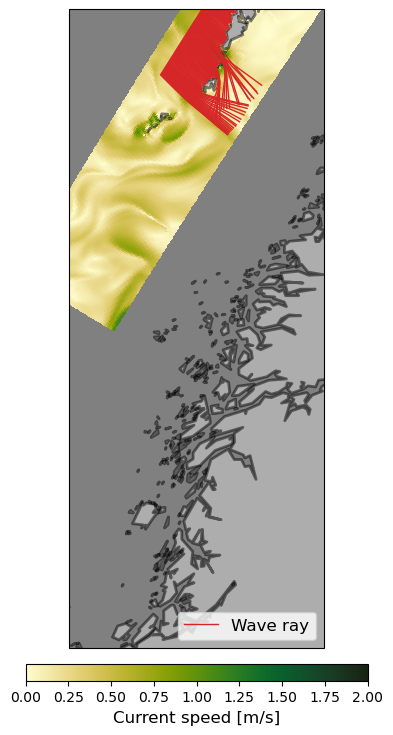

In [29]:
fig, ax = plt.subplots(frameon=False,ncols=1,figsize=(6,8),sharex=True,sharey=True,
                subplot_kw={'projection': ccrs.Mercator(), 'facecolor':"gray"})
speed = np.sqrt(uu**2 + vv**2)

cf0=ax.pcolormesh(da_u.lon, da_u.lat, speed[:,:],
                           cmap=cmocean.cm.speed, vmax=2, transform=ccrs.PlateCarree())

step=1
for i in range(0,wt.nb_wave_rays,step):
    if i == 0:
        ax.plot(lons_wc[i,:],lats_wc[i,:],'-',c='tab:red',
                transform=ccrs.PlateCarree(),alpha=1,lw=1,label='Wave ray')
    else:
        ax.plot(lons_wc[i,:],lats_wc[i,:],'-',c='tab:red',transform=ccrs.PlateCarree(),alpha=1,lw=1)

#for i in range(0,wt.nb_wave_rays,1):
#    ax.plot(lons_wc[i,:],lats_wc[i,:],'-',c='tab:red',transform=ccrs.PlateCarree(),alpha=1,lw=1)
#    ax2[1].plot(lons_nc[i,:],lats_nc[i,:],'-',c='tab:red',transform=ccrs.PlateCarree(),alpha=1,lw=1)

ax.legend(fontsize=fs,loc='lower right')


ax.set_extent(plot_extent, geodetic)
ax.add_geometries(
        f.intersecting_geometries([lonmin, lonmax, latmin-.1, latmax]),
        ccrs.PlateCarree(),
        facecolor=cfeature.COLORS['land_alt1'],
        edgecolor='black',alpha=0.5,linewidth=2)

cb = fig.colorbar(cf0, orientation='horizontal',shrink=0.6,pad=0.02)
cb.set_label('Current speed [m/s]',fontsize=fs)

cb.ax.tick_params(labelsize=fs-2) 

ax.tick_params(labelsize=fs)


fig.tight_layout()

## Export wave rays to NetCDF

In [20]:
ds_wt = wt.to_ds(proj4=proj4)

In [21]:
print(ds_wt)

<xarray.Dataset> Size: 5MB
Dimensions:    (ray_id: 140, time: 400)
Coordinates:
  * ray_id     (ray_id) int32 560B 0 1 2 3 4 5 6 ... 133 134 135 136 137 138 139
  * time       (time) float64 3kB 0.0 10.83 21.65 ... 4.309e+03 4.32e+03
Data variables:
    ray_k      (ray_id, time) float64 448kB 0.02386 0.02385 0.02384 ... nan nan
    ray_kx     (ray_id, time) float64 448kB -0.005204 -0.005201 ... nan nan
    ray_ky     (ray_id, time) float64 448kB -0.02328 -0.02327 ... nan nan
    ray_x      (ray_id, time) float64 448kB 1.2e+06 1.2e+06 1.2e+06 ... nan nan
    ray_y      (ray_id, time) float64 448kB 5.35e+05 5.349e+05 ... nan nan
    ray_U      (ray_id, time) float64 448kB -0.09225 -0.09225 ... 0.2281 0.0
    ray_V      (ray_id, time) float64 448kB 0.3038 0.3038 0.2807 ... 1.017 0.0
    ray_theta  (ray_id, time) float64 448kB -1.791 4.493 4.493 ... nan nan nan
    ray_cg     (ray_id, time) float64 448kB 10.35 10.35 10.35 ... nan nan nan
    ray_depth  (ray_id, time) float64 448kB 132.6 13